## Imports

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer
from src.analysis.graph_community_analyzer_graph_tool import GraphCommunityAnalyzerGraphTool

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from graph_tool.all import load_graph, GraphView, graph_draw, prop_to_size, closeness, eigenvector
from graph_tool import openmp_set_num_threads


(ipykernel_launcher.py:43735): dbind-WARNING **: 10:00:27.566: AT-SPI: Error retrieving accessibility bus address: org.freedesktop.DBus.Error.ServiceUnknown: The name org.a11y.Bus was not provided by any .service files


In [2]:
from src.analysis.utils import get_node_ids_from_community, plot_stats_for_category_quarterly

from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db

db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)


Database initialized: wikipedia.db


## Initialize Graphs

In [3]:
openmp_set_num_threads(8)

# 'Artificial intelligence' not yet done
graph_names = ['Amiga_CD32_games', 'Machine_learning','Game_Boy_games']

graphs = [{"graph_name": graph_name, "graph": load_graph('outputs/graphs/{}.gt'.format(graph_name))} for graph_name in graph_names]


In [4]:
for graph_instance in graphs:
    print(f"-------------Graph: {graph_instance['graph_name']}-------------")
    num_nodes = graph_instance['graph'].num_vertices()
    num_edges = graph_instance['graph'].num_edges()

    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")


-------------Graph: Amiga_CD32_games-------------
Number of nodes: 8013
Number of edges: 1537410
-------------Graph: Machine_learning-------------
Number of nodes: 75217
Number of edges: 26149964
-------------Graph: Game_Boy_games-------------
Number of nodes: 8953
Number of edges: 4095265


## Community detection

In [5]:
graph_comm = graphs[0]['graph']
graph_name = graphs[0]['graph_name']

graph_community_analyzer = GraphCommunityAnalyzerGraphTool(graph_comm, 'outputs/graphs/{}_communities'.format(graph_name))
# graph_community_analyzer.calc_minimize_blockmodel_dl(output_plot=False)

Graph: 8013 vertices, 1537410 edges
Randomized Graph: 8013 vertices, 1537410 edges


In [6]:
mod_state = graph_community_analyzer.calc_modularity_maximization(output_plot=False,niter=2000)
mod_state_random = graph_community_analyzer.calc_modularity_maximization(output_plot=False, niter=2000, is_random=True)

Number of blocks: 23
Number of blocks: 15


### Get community vertex property

In [7]:
print(f"communities {graph_community_analyzer.communities}")
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()
property_map_communities_random = graph_community_analyzer.communities['communities_modularity_random'].get_array()


communities {'communities_modularity': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7fc5644e7b50, at 0x7fc56449dc90>, 'communities_modularity_random': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7fc566e39610, at 0x7fc5567154d0>}


### Plot community sizes

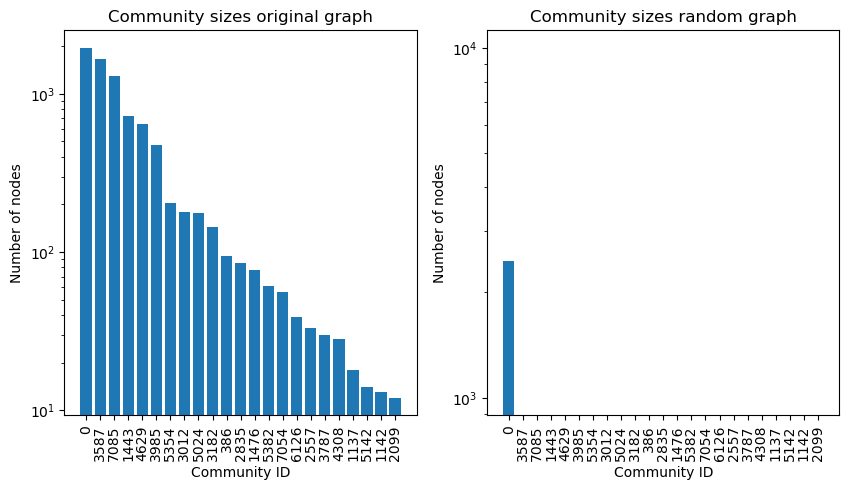

In [23]:
#plot community sizes

community_counts = Counter(property_map_communities)
community_counts_random = Counter(property_map_communities_random)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)
sorted_list_of_community_ids_by_size_random = sorted(community_counts_random, key=community_counts_random.get, reverse=True)



fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sorted_community_counts = {community: community_counts[community] for community in sorted_list_of_community_ids_by_size}

x_label_strings = [f'{community}' for community in sorted_community_counts.keys()]
x = np.arange(len(sorted_community_counts.keys()))
axs[0].bar(x, sorted_community_counts.values())
axs[0].set_title('Community sizes original graph')
axs[0].set_xlabel('Community ID')
axs[0].set_ylabel('Number of nodes')
axs[0].set_yscale('log')
axs[0].set_xticks(x)
axs[0].set_xticklabels(x_label_strings, rotation=90)

sorted_community_counts_random = {community: community_counts_random[community] for community in sorted_list_of_community_ids_by_size}
x_label_strings_random = [f'{community}' for community in sorted_community_counts_random.keys()]
x_random = np.arange(len(sorted_community_counts_random.keys()))
axs[1].bar(x_random, sorted_community_counts_random.values())
axs[1].set_title('Community sizes random graph')
axs[1].set_xlabel('Community ID')
axs[1].set_ylabel('Number of nodes')
axs[1].set_yscale('log')
axs[1].set_xticks(x_random)
axs[1].set_xticklabels(x_label_strings_random, rotation=90)

plt.show()




## Visualize Biggest N Communities

Biggest communities: [(np.int32(0), 1954), (np.int32(3587), 1659), (np.int32(7085), 1299), (np.int32(1443), 721), (np.int32(4629), 645)]
len community_bool_filter: 8013
community_bool_filter: [ True  True  True  True  True  True  True False  True  True]
property_map_communities: [   0    0 3587    0    0    0    0 3985    0    0]
all values with True in community_bool_filter: [   0    0 3587 ... 1443    0 3587]
type of community_bool_filter: <class 'numpy.bool'>
count of community_bool_filter True values: 6278
color_map_from_biggest_communities_indexes {np.int32(0): '#729fcf', np.int32(3587): '#cfb372', np.int32(7085): '#cf7272', np.int32(1443): '#a172cf', np.int32(4629): '#72cfa7'}
vcolor type: <class 'graph_tool.VertexPropertyMap'>
filter_mask type: <class 'graph_tool.VertexPropertyMap'>


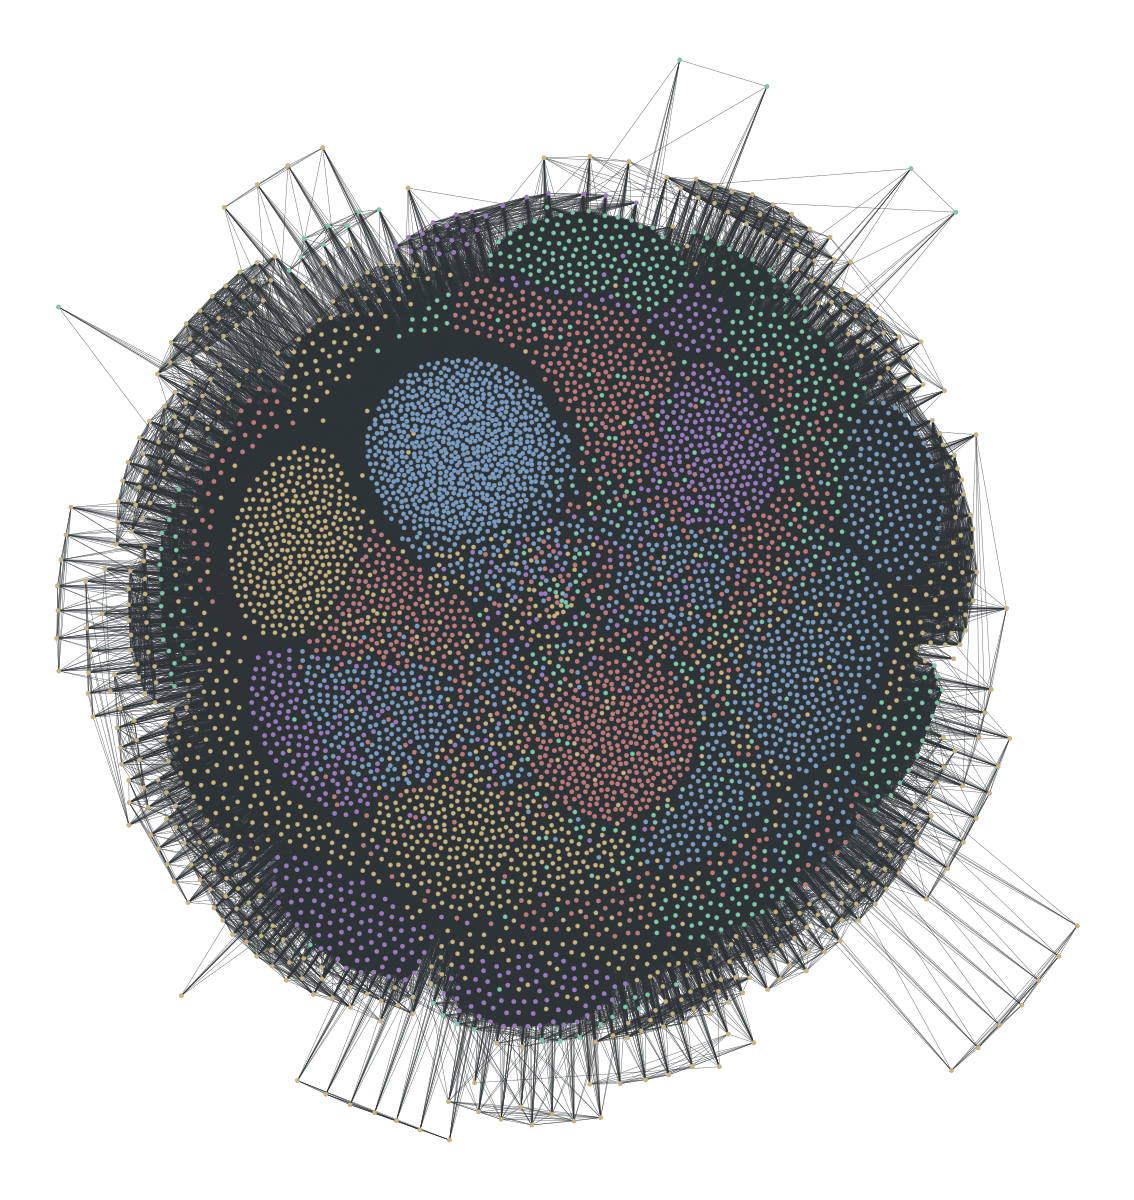

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc556610f90, at 0x7fc556317c90>

In [9]:
biggest_n_communities = 5

communities = Counter(property_map_communities)
biggest_communities = communities.most_common(biggest_n_communities)
print(f"Biggest communities: {biggest_communities}")

community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, biggest_n_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == biggest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

# color mapping for communities
color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7'}
# color_map = {0: '#729fcf', 1: '#cfb372', 2: '#cf7272', 3: '#a172cf', 4: '#72cfa7', 5: '#cf720f', 6: '#72ca72', 7: '#cf7202', 8: '#72cf72', 9: '#0f720f'}
color_map_from_biggest_communities_indexes = {biggest_communities[i][0]: color_map[i] for i in range(biggest_n_communities)}

print(f"color_map_from_biggest_communities_indexes {color_map_from_biggest_communities_indexes}")

vcolor = graph_community_analyzer.graph.new_vp("string") 

print(f"vcolor type: {type(vcolor)}")
print(f"filter_mask type: {type(filter_mask)}")

for v in graph_community_analyzer.graph.vertices():
    if graph_community_analyzer.graph.vertex_index[v] in np.where(community_bool_filter)[0]:
        vcolor[v] = color_map_from_biggest_communities_indexes[property_map_communities[graph_community_analyzer.graph.vertex_index[v]]]

# fill all vcolor values with black if not in filter_mask
for v in graph_community_analyzer.graph.vertices():
    if vcolor[v] == "":
        vcolor[v] = '#000000'

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=vcolor)






## Visualize smallest N communities

Smallest communities: [(np.int32(2099), 12), (np.int32(1142), 13), (np.int32(5142), 14), (np.int32(1137), 18), (np.int32(4308), 28), (np.int32(3787), 30), (np.int32(2557), 33), (np.int32(6126), 39)]
len community_bool_filter: 8013
community_bool_filter: [False False False False False False False False False False]
property_map_communities: [   0    0 3587    0    0    0    0 3985    0    0]
all values with True in community_bool_filter: [1137 1137 4308 4308 6126 4308 6126 6126 6126 4308 6126 6126 6126 1137
 6126 6126 1137 6126 6126 6126 6126 4308 3787 3787 3787 4308 3787 4308
 6126 1137 4308 2557 4308 2557 2557 1137 6126 3787 2557 6126 2557 3787
 6126 3787 6126 5142 5142 2557 1137 4308 4308 5142 2099 2099 3787 4308
 6126 1137 2099 2557 5142 4308 2099 2099 2557 5142 2099 2099 6126 5142
 5142 6126 2557 2557 2557 3787 5142 1137 5142 3787 5142 2557 4308 4308
 5142 6126 1137 1137 1137 3787 1137 6126 6126 2557 2557 3787 3787 2557
 3787 3787 1137 4308 1137 3787 1137 6126 3787 2557 2557 2099 6

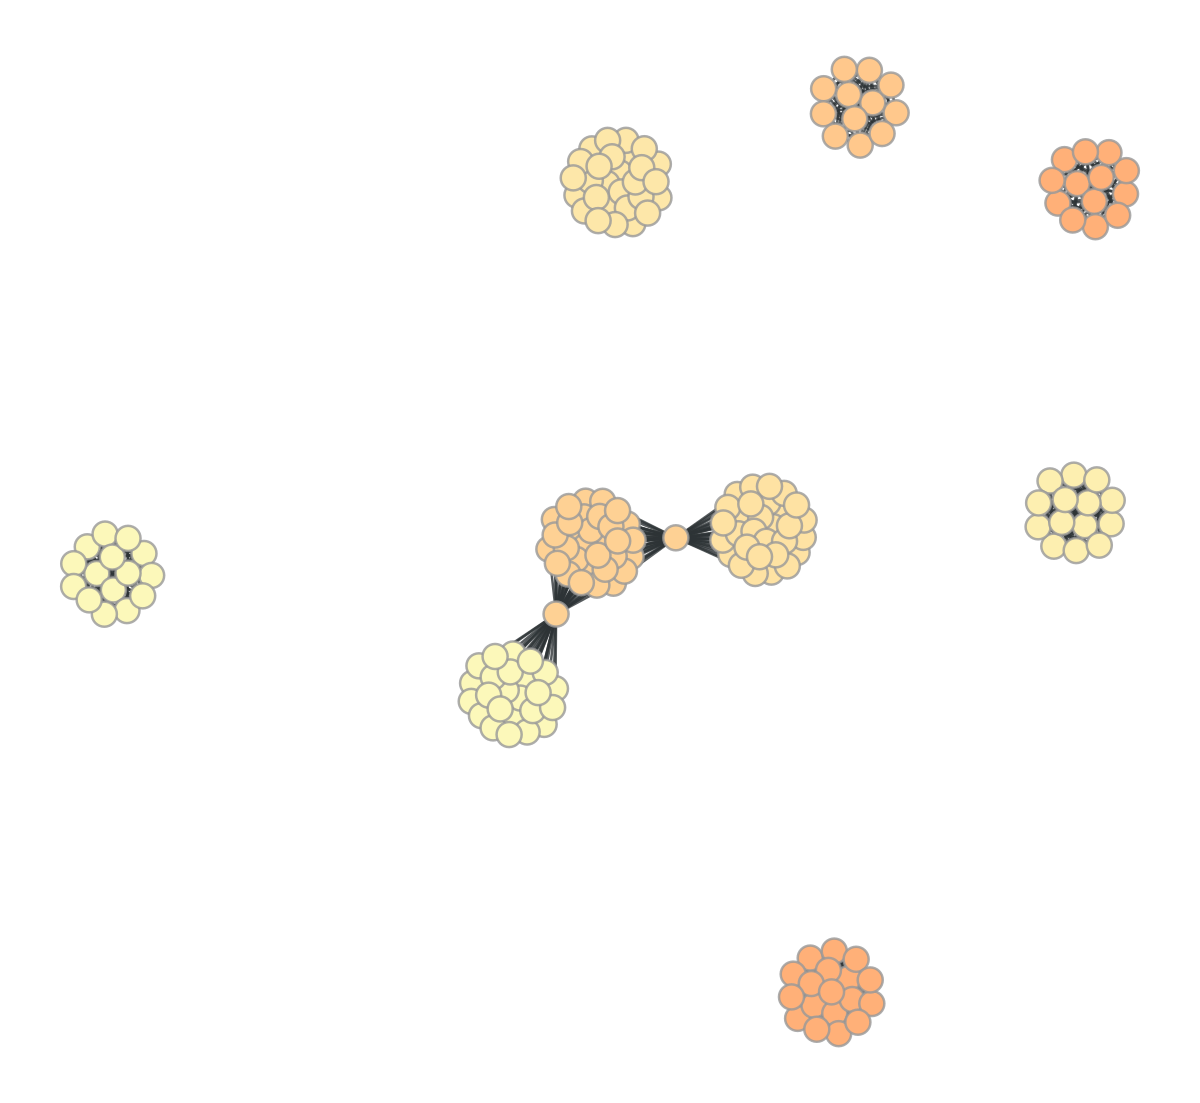

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc556467bd0, at 0x7fc5565a3310>

In [10]:
n_smallest_communities = 8

smallest_communities = communities.most_common()[:-(n_smallest_communities+1):-1]
print(f"Smallest communities: {smallest_communities}")

community_bool_filter = np.where(property_map_communities == smallest_communities[0][0], True, False)
# community_bool_filter = np.where(property_map_communities == biggest_communities[0][0], True, False)
for i in range(1, n_smallest_communities):
    community_bool_filter = np.logical_or(community_bool_filter, np.where(property_map_communities == smallest_communities[i][0], True, False))
print(f"len community_bool_filter: {len(community_bool_filter)}")
print(f"community_bool_filter: {community_bool_filter[:10]}")
print(f"property_map_communities: {property_map_communities[:10]}")

print(f"all values with True in community_bool_filter: {property_map_communities[community_bool_filter]}")

print(f"type of community_bool_filter: {type(community_bool_filter[0])}")
print(f"count of community_bool_filter True values: {np.count_nonzero(community_bool_filter)}")

filter_mask = graph_community_analyzer.graph.new_vertex_property('bool', vals=community_bool_filter)

# graph_community_analyzer.graph.set_vertex_filter(filter_mask)

u = GraphView(graph_community_analyzer.graph, vfilt=filter_mask)
graph_draw(u, vertex_fill_color=prop_to_size(graph_community_analyzer.communities['communities_modularity'], 0,1, power=.1))


## Get statistics of communities

### Init DB to query contributor information

In [11]:
from src.acquisition.models.database_manager import DatabaseManager
from src.acquisition.models.db.database import db
from src.acquisition.models.db.database import initialize_db
from datetime import datetime

db_category_names = ['Amiga CD32 games', 'Machine learning', 'Game Boy games', 'Artificial intelligence']

category_name  = db_category_names[0]
db_name = 'wikipedia.db'
initialize_db(db_name)  
db_manager = DatabaseManager(db)

Database initialized: wikipedia.db


In [12]:
def get_edit_stats_for_category(graph_community_analyzer, category_name):
    main_category_id = db_manager.get_main_category_by_name(category_name)

    # get all vertex properties
    vertex_properties = graph_community_analyzer.graph.vertex_properties
    #get id property
    id_property = vertex_properties['id']

    # construct a dict with the community as key and the nodes, stats as values
    community_stats = {'max': {}, 'min': {}, 'avg': {}, 'total': {}}
    community_nodes = {}
    community_nodes_nb_edits = {}
    nodes_oldest_edit = {}
    nodes_newest_edit = {}
    community_oldest_edit = {}
    community_newest_edit = {}

    for v in graph_community_analyzer.graph.vertices():
        community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]
        if community not in community_nodes:
            community_nodes[community] = []
            community_nodes_nb_edits[community] = []
        community_nodes[community].append(v)
        community_nodes_nb_edits[community].append(db_manager.get_number_of_revisions_per_contributor(id_property[v], main_category_id))
        node_edit_dates = db_manager.get_oldest_and_newest_revision_per_contributor_and_main_category(id_property[v], main_category_id)

        #parse date string as datetime
        node_edit_dates['oldest_revision'] = datetime.strptime(node_edit_dates['oldest_revision'], '%Y-%m-%dT%H:%M:%SZ')
        node_edit_dates['newest_revision'] = datetime.strptime(node_edit_dates['newest_revision'], '%Y-%m-%dT%H:%M:%SZ')

        nodes_oldest_edit[int(v)] = node_edit_dates['oldest_revision']
        nodes_newest_edit[int(v)] = node_edit_dates['newest_revision']
        
        if community not in community_oldest_edit:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']
            community_newest_edit[community] = node_edit_dates['newest_revision']

        if community_oldest_edit[community] > node_edit_dates['oldest_revision']:
            community_oldest_edit[community] = node_edit_dates['oldest_revision']

        if community_newest_edit[community] < node_edit_dates['newest_revision']:
            community_newest_edit[community] = node_edit_dates['newest_revision']

    for community in community_nodes_nb_edits.keys():
        community_stats['max'][community] = np.max(community_nodes_nb_edits[community])
        community_stats['min'][community] = np.min(community_nodes_nb_edits[community])
        community_stats['avg'][community] = np.mean(community_nodes_nb_edits[community])
        community_stats['total'][community] = np.sum(community_nodes_nb_edits[community])

    print(f"community_nodes: {community_nodes}")
    print(f"len community_nodes: {len(community_nodes.keys())}")

    #Total number of edits in category
    print(f"Total number of edits in category {category_name}: {db_manager.get_total_number_of_revisions_per_main_category(main_category_id)}")
    #Average number of edits per contributor
    print(f"Average edits of category {category_name}: {np.mean([np.mean(community_nodes_nb_edits[community]) for community in community_nodes_nb_edits.keys()])}")

    return community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit

community_stats, nodes_oldest_edit, nodes_newest_edit, community_nodes_nb_edits, community_oldest_edit, community_newest_edit = get_edit_stats_for_category(graph_community_analyzer, category_name)


community_nodes: {np.int32(0): [<Vertex object with index '0' at 0x7fc5562b34c0>, <Vertex object with index '1' at 0x7fc5564816c0>, <Vertex object with index '3' at 0x7fc5ef30e2c0>, <Vertex object with index '4' at 0x7fc5562b35c0>, <Vertex object with index '5' at 0x7fc5562b3cc0>, <Vertex object with index '6' at 0x7fc5562b3740>, <Vertex object with index '8' at 0x7fc5566ef0c0>, <Vertex object with index '9' at 0x7fc5562b3ec0>, <Vertex object with index '10' at 0x7fc5566ee0c0>, <Vertex object with index '11' at 0x7fc5561483c0>, <Vertex object with index '12' at 0x7fc556149540>, <Vertex object with index '13' at 0x7fc5561494c0>, <Vertex object with index '14' at 0x7fc556149dc0>, <Vertex object with index '18' at 0x7fc556148ac0>, <Vertex object with index '20' at 0x7fc556149440>, <Vertex object with index '21' at 0x7fc5561493c0>, <Vertex object with index '24' at 0x7fc5561486c0>, <Vertex object with index '26' at 0x7fc556148fc0>, <Vertex object with index '27' at 0x7fc556148540>, <Vertex

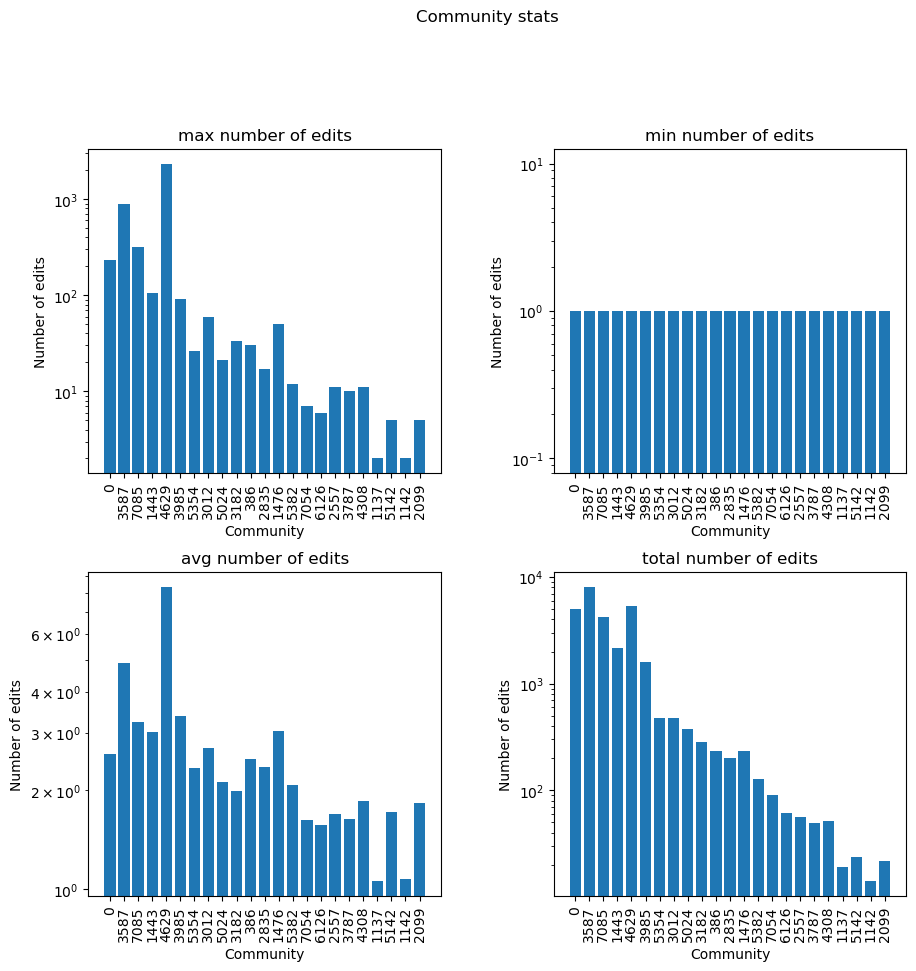

In [13]:
#plot distribution of stats over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community stats')
fig.tight_layout(pad=5.0)

for i, stat in enumerate(community_stats.keys()):
    ax = axs[i//2, i%2]

    # sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
    sorted_community_stats = {community: community_stats[stat][community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_community_stats.keys()]
    x = np.arange(len(sorted_community_stats.keys()))
    y = list(sorted_community_stats.values())
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_yscale('log')
    ax.set_title(f'{stat} number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel('Community')
    
plt.show()

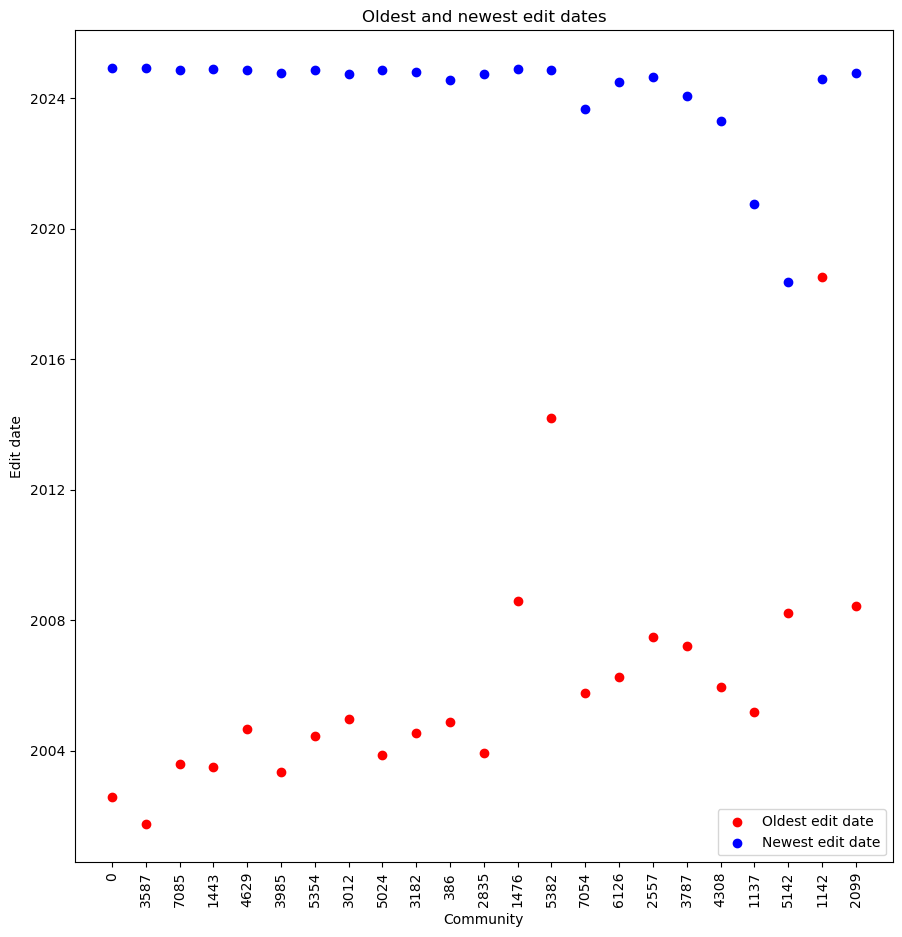

In [14]:
# plot oldest and newest edit dates as scatter plot with the oldest and newest edit dates as different colors for each community in the y-axis

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.tight_layout(pad=5.0)

# sort the community stats according to the order of the sorted_list_of_community_ids_by_size list
sorted_oldest_edit = {community: community_oldest_edit[community] for community in sorted_list_of_community_ids_by_size}
sorted_newest_edit = {community: community_newest_edit[community] for community in sorted_list_of_community_ids_by_size}

x = np.arange(len(sorted_oldest_edit.keys()))
x_label_strings = [f'{community}' for community in sorted_oldest_edit.keys()]
y1 = sorted_oldest_edit.values()
y2 = sorted_newest_edit.values()
# print(len(x), len(y1), len(y2))

# print(type(list(y1)[0]))

# print(x)
# print(y1)
ax.scatter(x, y1, color='r', label='Oldest edit date')
ax.scatter(x, y2, color='b', label='Newest edit date')
ax.set_xticks(x)
ax.set_xticklabels(x_label_strings, rotation=90)
ax.set_title('Oldest and newest edit dates')
ax.set_ylabel('Edit date')
ax.set_xlabel('Community')
ax.legend()

plt.show()

### Timeline of edits in a community

In [15]:
property_map_communities = graph_community_analyzer.communities['communities_modularity'].get_array()

community_counts = Counter(property_map_communities)

sorted_list_of_community_ids_by_size = sorted(community_counts, key=community_counts.get, reverse=True)

first_id = sorted_list_of_community_ids_by_size[0]
last_id = sorted_list_of_community_ids_by_size[-1]

nodes_in_community_first = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], first_id)
nodes_in_community_last = get_node_ids_from_community(graph_comm, graph_community_analyzer.communities['communities_modularity'], last_id)

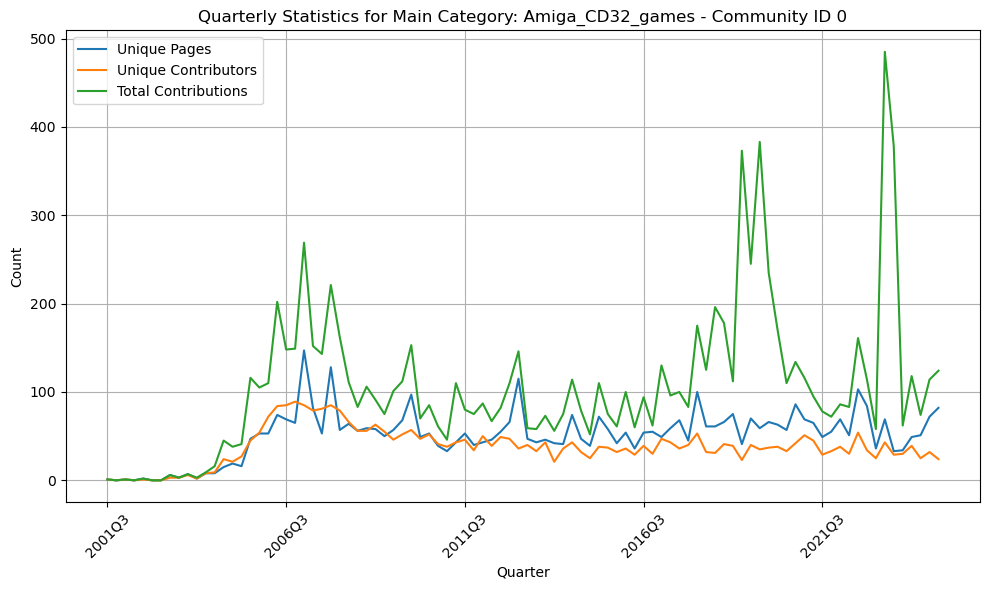

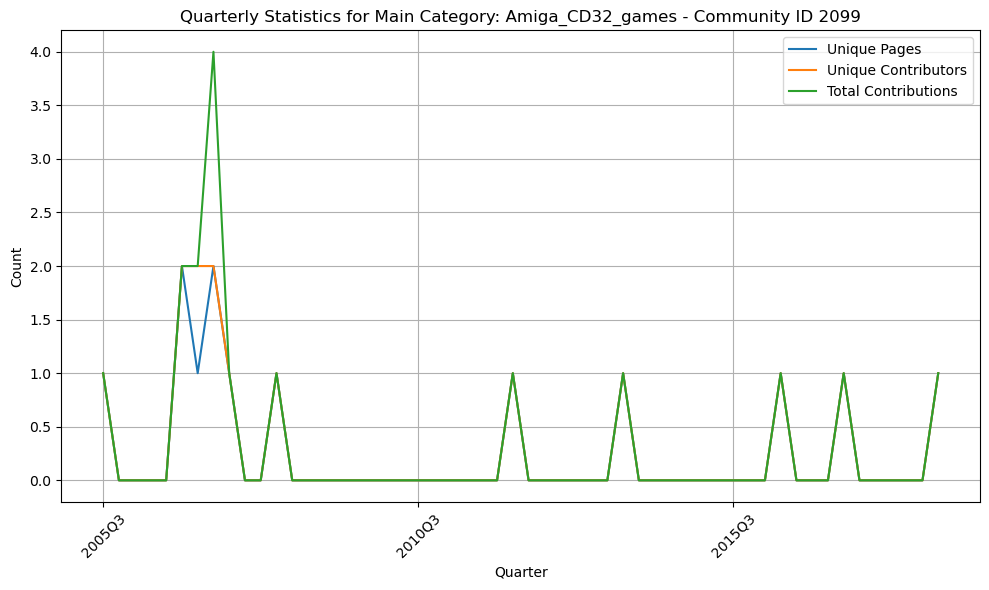

In [16]:

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_first)
plot_stats_for_category_quarterly(df, f'Amiga_CD32_games - Community ID {first_id}')

df = db_manager.get_unique_stats_per_month(1 , contributor_ids=nodes_in_community_last)
plot_stats_for_category_quarterly(df, f'Amiga_CD32_games - Community ID {last_id}')

## Analyze graph properties and plot them per community

In [17]:
centrality_analyzer = CentralityAnalyzer(graph_community_analyzer.graph)
centrality_analyzer.calculate_centralities()

closn = centrality_analyzer.get_closeness_centrality()
eigenv = centrality_analyzer.get_eigenvector_centrality()
betweenness = centrality_analyzer.get_betweenness_centrality()
degrees = centrality_analyzer.get_degrees()




Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 0.11 seconds.

Calculating closeness...
Closeness centrality calculated in 36.11 seconds.

Calculating betweenness...
Betweenness centrality calculated in 45.29 seconds.



In [18]:
community_closeness = {}
community_eigenvector = {}
community_betweenness = {}
community_degrees = {}

# get closeness centrality for each community
for v in graph_community_analyzer.graph.vertices():
    community = property_map_communities[graph_community_analyzer.graph.vertex_index[v]]

    if community not in community_closeness:
        community_closeness[community] = []
    community_closeness[community].append(closn[graph_community_analyzer.graph.vertex_index[v]])

    # get eigenvector centrality for each community
    if community not in community_eigenvector:
        community_eigenvector[community] = []
    community_eigenvector[community].append(eigenv[graph_community_analyzer.graph.vertex_index[v]])

    # get betweenness centrality for each community
    if community not in community_betweenness:
        community_betweenness[community] = []
    community_betweenness[community].append(betweenness[graph_community_analyzer.graph.vertex_index[v]])

    # get degrees for each community
    if community not in community_degrees:
        community_degrees[community] = []
    community_degrees[community].append(degrees[graph_community_analyzer.graph.vertex_index[v]])


### Get usernames of high centrality nodes

In [19]:
top_N_centrality_nodes = 20

top_closeness_nodes = np.flip(np.argsort(closn)[-top_N_centrality_nodes:])
top_eigenvector_nodes = np.flip(np.argsort(eigenv)[-top_N_centrality_nodes:])
top_betweenness_nodes = np.flip(np.argsort(betweenness)[-top_N_centrality_nodes:])
top_degree_nodes = np.flip(np.argsort(degrees)[-top_N_centrality_nodes:])

top_closeness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_closeness_nodes]
top_eigenvector_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_eigenvector_nodes]
top_betweenness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_betweenness_nodes]
top_degree_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in top_degree_nodes]

top_closeness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_closeness_nodes_ids]
top_eigenvector_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_eigenvector_nodes_ids]
top_betweenness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_betweenness_nodes_ids]
top_degree_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in top_degree_nodes_ids]
 
print("------------ Closeness ---------------")
for i in range(len(top_closeness_nodes)):
    print(f"{closn[top_closeness_nodes[i]]} &\t {top_closeness_nodes_usernames[i]}")

print("------------ Eigenvector ---------------")
for i in range(len(top_eigenvector_nodes)):
    print(f"{eigenv[top_eigenvector_nodes[i]]} &\t {top_eigenvector_nodes_usernames[i]}")

print("------------ Betweenness ---------------")
for i in range(len(top_betweenness_nodes)):
    print(f"{betweenness[top_betweenness_nodes[i]]} &\t {top_betweenness_nodes_usernames[i]}")

print("------------ Degree ---------------")
for i in range(len(top_degree_nodes)):
    print(f"{degrees[top_degree_nodes[i]]} &\t {top_degree_nodes_usernames[i]}")



------------ Closeness ---------------
0.9946617008069523 &	 JJMC89 bot III
0.9408172851103805 &	 Cydebot
0.9392731535756155 &	 Waxworker
0.9165999313579682 &	 Addbot
0.9154478976234004 &	 Mika1h
0.9017445132245357 &	 Citation bot
0.876970227670753 &	 Monkbot
0.8708695652173913 &	 X201
0.8538846850687413 &	 BetacommandBot
0.8301730390633095 &	 Phediuk
0.8278569952469519 &	 AnomieBOT
0.8177179016125741 &	 SmackBot
0.8039333734697973 &	 InternetArchiveBot
0.7903719049028312 &	 Dgpop
0.7768835450402405 &	 IceWelder
0.7702364929821188 &	 The1337gamer
0.7697185128254396 &	 KGRAMR
0.7532198928269248 &	 GreenC bot
0.7339684866251374 &	 N. Harmonik
0.7338340355376443 &	 Martin IIIa
------------ Eigenvector ---------------
0.04626750201797861 &	 JJMC89 bot III
0.045883318159803316 &	 Cydebot
0.04548219473198394 &	 Mika1h
0.04544820704251546 &	 Addbot
0.04538640605867541 &	 Citation bot
0.04529194178452354 &	 Waxworker
0.044880723669118786 &	 Monkbot
0.04434572494731183 &	 X201
0.044342891327652

### Get usernames of low centrality nodes

In [20]:
bottom_N_centrality_nodes = 20


bottom_closeness_nodes = np.argsort(closn)[:bottom_N_centrality_nodes]
bottom_eigenvector_nodes = np.argsort(eigenv)[:bottom_N_centrality_nodes]
bottom_betweenness_nodes = np.argsort(betweenness)[:bottom_N_centrality_nodes]
bottom_degree_nodes = np.argsort(degrees)[:bottom_N_centrality_nodes]

bottom_closeness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_closeness_nodes]
bottom_eigenvector_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_eigenvector_nodes]
bottom_betweenness_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_betweenness_nodes]
bottom_degree_nodes_ids = [graph_community_analyzer.graph.vertex_properties['id'][v] for v in bottom_degree_nodes]

bottom_closeness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_closeness_nodes_ids]
bottom_eigenvector_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_eigenvector_nodes_ids]
bottom_betweenness_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_betweenness_nodes_ids]
bottom_degree_nodes_usernames = [db_manager.get_contributor_username(node_id) for node_id in bottom_degree_nodes_ids]

print("------------ Closeness ---------------")
for i in range(len(bottom_closeness_nodes)):
    print(f"{closn[bottom_closeness_nodes[i]]} &\t {bottom_closeness_nodes_usernames[i]}")

print("------------ Eigenvector ---------------")
for i in range(len(bottom_eigenvector_nodes)):
    print(f"{eigenv[bottom_eigenvector_nodes[i]]} &\t {bottom_eigenvector_nodes_usernames[i]}")

print("------------ Betweenness ---------------")
for i in range(len(bottom_betweenness_nodes)):
    print(f"{betweenness[bottom_betweenness_nodes[i]]} &\t {bottom_betweenness_nodes_usernames[i]}")

print("------------ Degree ---------------")
for i in range(len(bottom_degree_nodes)):
    print(f"{degrees[bottom_degree_nodes[i]]} &\t {bottom_degree_nodes_usernames[i]}")


------------ Closeness ---------------
0.4937754221619623 &	 Egeymi
0.49748525302701024 &	 145.224.66.225
0.49748525302701024 &	 Emilypblake
0.49748525302701024 &	 Kstone999
0.49748525302701024 &	 Ben79487
0.49748525302701024 &	 MadameButterflyKnife
0.49748525302701024 &	 Gamerguy38
0.49748525302701024 &	 PWorrell10
0.49748525302701024 &	 WJG400
0.49748525302701024 &	 TrueNeutral14
0.49748525302701024 &	 Rachel.glitza
0.49748525302701024 &	 46.211.95.231
0.49748525302701024 &	 Spirernc
0.49748525302701024 &	 The bandoleer
0.5003122268015486 &	 64.77.244.70
0.5003434709298695 &	 Woodlot
0.5003434709298695 &	 Bearcat
0.5003747189607795 &	 Ninja Diannaa
0.5003747189607795 &	 Nthep
0.5004059708950097 &	 The Blade of the Northern Lights
------------ Eigenvector ---------------
0.0001813737740553516 &	 112.165.121.143
0.0001813737740553516 &	 Rosguill
0.0001813737740553516 &	 The Blade of the Northern Lights
0.0001813737740553516 &	 AcePilot19
0.0001813737740553516 &	 ScrollPatrol
0.00018137

### Plot distributions of mean centrality measures per community

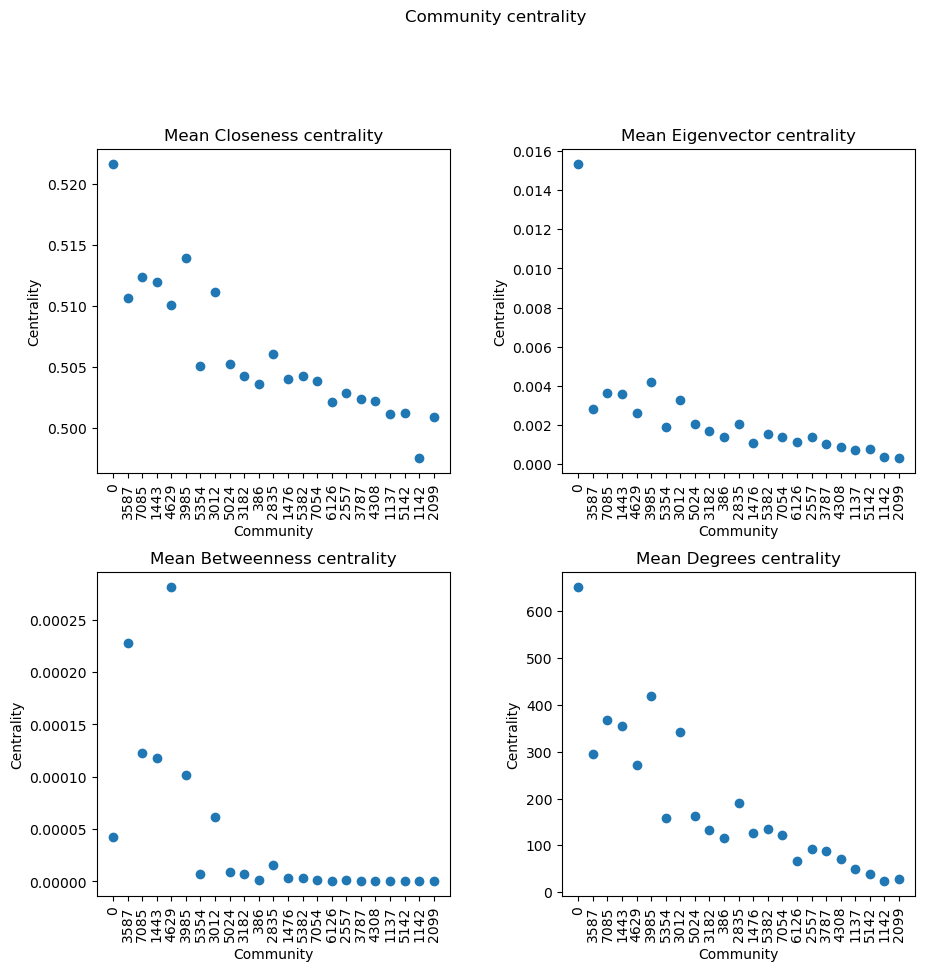

In [21]:
#plot distribution of closeness and eigenvector centrality over communities

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Community centrality')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'

    sorted_centrality = {community: centrality[community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_centrality.keys()]
    x = np.arange(len(sorted_centrality.keys()))
    y = [np.mean(sorted_centrality[community]) for community in sorted_centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'

    sorted_centrality = {community: centrality[community] for community in sorted_list_of_community_ids_by_size}

    x_label_strings = [f'{community}' for community in sorted_centrality.keys()]
    x = np.arange(len(sorted_centrality.keys()))
    y = [np.mean(sorted_centrality[community]) for community in sorted_centrality.keys()]
    ax.scatter(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(x_label_strings, rotation=90)
    ax.set_title(f'Mean {chart_title} centrality')
    ax.set_ylabel('Centrality')
    ax.set_xlabel('Community')

plt.show()


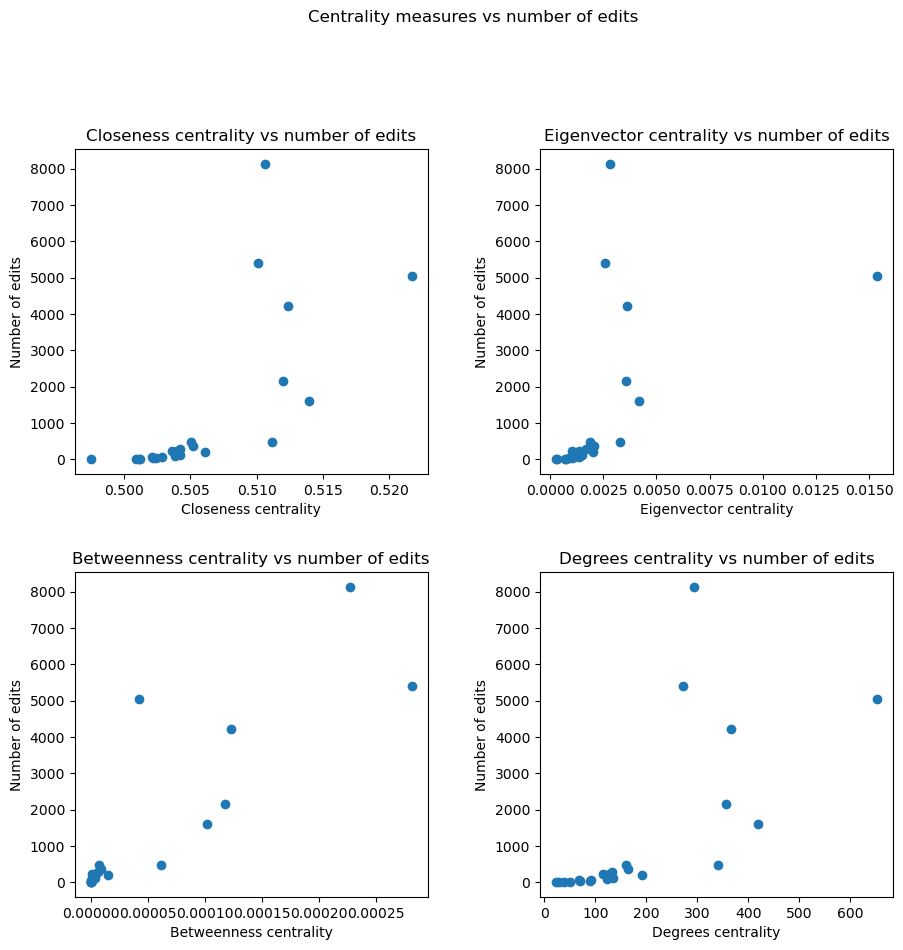

In [22]:
# plot centrality measures against number of edits for each community

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Centrality measures vs number of edits')
fig.tight_layout(pad=5.0)

for i, centrality in enumerate([community_closeness, community_eigenvector]):
    ax = axs[0][i]
    chart_title = 'Closeness' if i == 0 else 'Eigenvector'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    labels = [f'{community}' for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')

for i, centrality in enumerate([community_betweenness, community_degrees]):
    ax = axs[1][i]
    chart_title = 'Betweenness' if i == 0 else 'Degrees'
    x = [np.mean(centrality[community]) for community in centrality.keys()]
    y = [np.sum(community_nodes_nb_edits[community]) for community in centrality.keys()]
    ax.scatter(x, y)
    ax.set_title(f'{chart_title} centrality vs number of edits')
    ax.set_ylabel('Number of edits')
    ax.set_xlabel(f'{chart_title} centrality')